In [1]:
def Run_MNIST_Exp(Num_Epochs):
    %matplotlib notebook
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D,MaxPool2D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz
    import seaborn as sns

    from keras.layers.core import Lambda
    from keras import backend as K    


    def mini_batches(InputSample,BatchSize):
        Index = np.array(range(InputSample.shape[0]),dtype=int)
        NumBatches = np.int(InputSample.shape[0]/BatchSize)
        Removed = np.array([],dtype=int)

        BatchInd =[]
        for BatchLoop in range(NumBatches):
            RemainIndex = np.delete(Index,Removed)
            SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
            Removed = np.append(Removed,SampleInd,axis=0)

            BatchInd.append(SampleInd)
        RemainIndex = np.delete(Index,Removed)
        BatchInd.append(RemainIndex)

        return BatchInd,NumBatches

    def Get_Feats_and_Targets(filename):
        import numpy as np

        def line_to_Feats(line):
            line = line.split(' ')
            Feats = np.asarray(line[0:1024])
            Target = np.zeros([3])
            Target[int(line[1024])] = 1
            return Feats,Target

        f = open(filename, 'r')
        lines = f.readlines()
        Features = []
        Targets = []
        for i in range(len(lines)-1):
            line = lines[i+1]
            Feats,Tgts = line_to_Feats(line)
            Features.append(Feats)
            Targets.append(Tgts)

        return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

    
    ConvFlag = 0
    
    FullInputs = scipy.io.loadmat('MNIST_TrainInputs.mat')
    FullInputs = FullInputs['images']

    FullTargets = scipy.io.loadmat('MNIST_TrainTargets.mat')
    FullTargets = FullTargets['targets']

    Validation_Cutoff = 0.75

    Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])

    ValInputs = FullInputs[Validation_Cutoff:,:]
    ValTargets = FullTargets[Validation_Cutoff:,:]

    TrainInputs = FullInputs[0:Validation_Cutoff,:]
    TrainTargets = FullTargets[0:Validation_Cutoff,:]
    
    if ConvFlag == 1:
        TrainInputs = TrainInputs.reshape([TrainInputs.shape[0],28,28,1])
        TrainInputs = np.swapaxes(TrainInputs,1,2)

        ValInputs = ValInputs.reshape([ValInputs.shape[0],28,28,1])
        ValInputs = np.swapaxes(ValInputs,1,2)
        
        data_dim2 = TrainInputs.shape[2]

    data_dim = TrainInputs.shape[1]
    NumSamples = TrainInputs.shape[0]
    Num_Targets = TrainTargets.shape[-1]

    index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

    reg_coeff = 0.001

    def Gen_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.00001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
        return model
        
#     def Gen_Model(reg_coeff):
#         model = Sequential()
#         model.add(Conv2D(100,5,activation='relu',input_shape =(data_dim,data_dim2,1)))
#         model.add(MaxPool2D())
#         model.add(Conv2D(100,5,activation='relu'))
#         model.add(MaxPool2D())
#         model.add(Flatten())
#         model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
#         model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
#         optim = optimizers.sgd(lr=0.001)
#         model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
#         return model

    VarTempModel = Gen_Model(reg_coeff)
    UniTaskModel = Gen_Model(reg_coeff)
    PropTaskModel = Gen_Model(reg_coeff)
    ConstTempModel = Gen_Model(reg_coeff)
    Uni_model = Gen_Model(reg_coeff)
    
    VarTempModel.set_weights(Uni_model.get_weights())
    UniTaskModel.set_weights(Uni_model.get_weights())
    PropTaskModel.set_weights(Uni_model.get_weights())
    ConstTempModel.set_weights(Uni_model.get_weights())
    
    def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Exp_Dist_to_Threshold *= 1
    #     Exp_Dist_to_Threshold = Dist_to_Threshold
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob

    def acquisition_function_dist_to_threshold_const_temp(model,samples,Num_Targets,temperature=1):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        return Sampling_Prob

    count = 0 
    Num_Epochs = Num_Epochs
    Num_BurnIn = 1
    Batch_Size = 64
    
    NumTasks = 5
    try:
        SwitchPoint = np.int(Num_Epochs/NumTasks)
        print('Switch:')
        print(SwitchPoint)
    except:
        SwitchPoint = 1
    Val_Error = np.zeros([Num_Epochs,5])
    Val_Acc = np.zeros([Num_Epochs,5])

    def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
        
    def Biased_Batch_Uni(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[TaskInd] = 1
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
            
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    fig2 = plt.figure(figsize = [4,4])
    ax2 = fig2.add_subplot(111)
    plt.ion()
    fig2.show()
    fig2.canvas.draw()


    for EpochLoop in  range(Num_Epochs):
        if count < Num_BurnIn:
            Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,:] = Error[0]
            Val_Acc[count,:] = Error[1]
        else:
            
            VarTempModel_Probability = 1/acquisition_function_dist_to_threshold(VarTempModel,TrainInputs,Num_Targets,1,100)
            VarTempModel_Probability/= VarTempModel_Probability.sum().astype(float)
            
            UniTaskModel_Probability = 1/acquisition_function_dist_to_threshold_const_temp(UniTaskModel,TrainInputs,Num_Targets,1)
            UniTaskModel_Probability/= UniTaskModel_Probability.sum().astype(float)
            
            PropTaskModel_Probability = 1/acquisition_function_dist_to_threshold(PropTaskModel,TrainInputs,Num_Targets,1,100)
            PropTaskModel_Probability/= PropTaskModel_Probability.sum().astype(float)
            
            ConstTempModel_Probability = 1/acquisition_function_dist_to_threshold_const_temp(ConstTempModel,TrainInputs,Num_Targets,0.5)
            ConstTempModel_Probability/= ConstTempModel_Probability.sum().astype(float)
            
            print(np.max(ConstTempModel_Probability)/np.min(ConstTempModel_Probability))
            
            VarTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,VarTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            UniTaskModel.fit_generator(Biased_Batch_Uni(TrainInputs,TrainTargets,Batch_Size,UniTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),  
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            PropTaskModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,PropTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            ConstTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ConstTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

            Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples),0),
                                    steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

            Error = VarTempModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,0] = Error[0]
            Val_Acc[count,0] = Error[1]

            Error = UniTaskModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,1] = Error[0]
            Val_Acc[count,1] = Error[1]
            
            Error = PropTaskModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,2] = Error[0]
            Val_Acc[count,2] = Error[1]
            
            Error = ConstTempModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]

            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,4] = Error[0]
            Val_Acc[count,4] = Error[1]
            
            print(EpochLoop)

        count += 1
        
        ax.clear()
        ax.plot(Val_Error[0:count,0],label='VarTemp')
        ax.plot(Val_Error[0:count,1],label='UniTask')
        ax.plot(Val_Error[0:count,2],label='PropTask')
        ax.plot(Val_Error[0:count,3],label='ConstTemp')
        ax.plot(Val_Error[0:count,4],label='Uniform')
        ax.legend(loc='best')
        fig.canvas.draw()

        ax2.clear()
        ax2.plot(Val_Acc[0:count,0],label='High D2T')
        ax2.plot(Val_Acc[0:count,1],label='UniTask')
        ax2.plot(Val_Acc[0:count,2],label='PropTask')
        ax2.plot(Val_Acc[0:count,3],label='ConstTemp')
        ax2.plot(Val_Acc[0:count,4],label='Uniform')
        fig2.canvas.draw()

    TestInputs = scipy.io.loadmat('MNIST_TestInputs.mat')
    TestInputs = TestInputs['test_images']
    TestTargets = scipy.io.loadmat('MNIST_TestTargets.mat')
    TestTargets = TestTargets['test_targets']
    
#     TestInputs = TestInputs.reshape([TestInputs.shape[0],28,28,1])
#     TestInputs = np.swapaxes(TestInputs,1,2)

    TestError = np.zeros([5,2])
    TestError[0,:] = VarTempModel.test_on_batch(TestInputs,TestTargets)
    TestError[1,:] = UniTaskModel.test_on_batch(TestInputs,TestTargets)
    TestError[2,:] = PropTaskModel.test_on_batch(TestInputs,TestTargets)
    TestError[3,:] = ConstTempModel.test_on_batch(TestInputs,TestTargets)
    TestError[4,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
    
    

    return TestError, Val_Error,Val_Acc

In [2]:
import numpy as np
import datetime
NumRuns = 100
NumEpochs = 100

TestError = np.zeros([5,2,NumRuns])
Val_Error = np.zeros([NumEpochs,5,NumRuns])
Val_Acc = np.zeros([NumEpochs,5,NumRuns])


2
Switch:
20


<IPython.core.display.Javascript object>


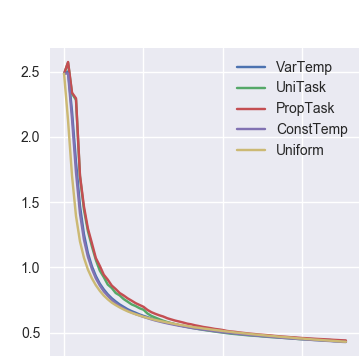

<IPython.core.display.Javascript object>


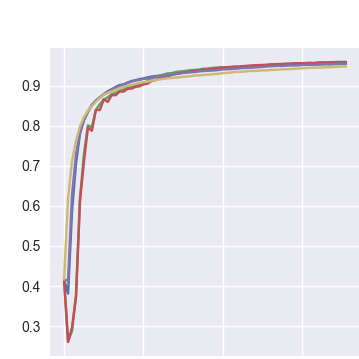

Epoch 1/1
45000/45000 [==============================] - 4s 94us/step - loss: 2.6410 - categorical_accuracy: 0.1606
2.1352382
1
2.590079
2
7.191209
3
15.452319
4
18.342749
5
22.596428
6
24.79815
7
25.154074
8
25.210617
9
24.638868
10
24.604502
11
22.836065
12
22.314177
13
21.841518
14
19.8077
15
18.679707
16
18.296331
17
17.329638
18
17.064577
19
16.853867
20
16.127632
21
16.2787
22
16.66531
23
17.084545
24
16.578276
25
16.867275
26
16.321571
27
16.743534
28
16.988075
29
16.250397
30
16.762375
31
16.219923
32
16.094065
33
15.449393
34
15.838337
35
15.880295
36
15.097015
37
15.147696
38
15.305536
39
15.201764
40
14.598343
41
14.669843
42
14.426971
43
14.634228
44
14.2376795
45
14.412131
46
14.191873
47
14.327744
48
13.856299
49
13.835114
50
13.350578
51
13.637675
52
13.037826
53
13.07059
54
13.043989
55
13.07836
56
13.129426
57
12.73916
58
13.072199
59
13.406613
60
13.129009
61
12.549252
62
13.342123
63
13.471805
64
13.251998
65
13.488941
66
13.175922
67
12.699144
68
13.265225
69
12.097

In [ ]:
from IPython.display import clear_output
for i in range(NumRuns):
    clear_output()
    print(i)
    TestError[:,:,i],Val_Error[:,:,i],Val_Acc[:,:,i] = Run_MNIST_Exp(NumEpochs)
    np.save("Test_Performance_MNIST_Various_CompBootstrap",TestError)
    np.save("Val_Error_MNIST_Various_CompBootstrap",Val_Error)
    np.save("Val_Acc_MNIST_Various_CompBootstrap",Val_Acc)
    


In [4]:
np.save("Test_Performance_MNIST_Conv",TestError)
np.save("Val_Error_MNIST_Conv",Val_Error)
np.save("Val_Acc_MNIST_Conv",Val_Acc)

In [8]:
Val_Error.shape

(1, 3)

In [1]:
5/3

1.6666666666666667

In [7]:
np.max([-33,0])

0